In [1]:
using BenchmarkTools,LinearAlgebra, SparseArrays, Interpolations, DelimitedFiles, NumericalIntegration,Plots,LoopVectorization,StaticArrays
using TimerOutputs, HDF5
# using CSV,DataFrames
include("/Users/albert/Documents/JuliaLandscape/src/read_txt_files.jl")
include("/Users/albert/Documents/JuliaLandscape/src/river_functions.jl")
include("/Users/albert/Documents/JuliaLandscape/src/solvers.jl")
include("/Users/albert/Documents/JuliaLandscape/src/others.jl")
include("/Users/albert/Documents/JuliaLandscape/src/FEM.jl")

quadraticmesh (generic function with 1 method)

In [2]:
iparallel       = 0            # 1 = parallel solvers
ievol           = 1            # 1 = plot evolution step-by-step, 0 = only 
igif            = 0            # 1 = make gif of evolution
yrs_Ma          = 1            # 1 = use Ma, 0 = yrs since start
isave           = 0            # 1 = save evolution in txt file; 0 = don"t 
imalatesta      = 1            # 1 = malatesta on
uplift_type     = "constant"   # "constant" or "armel"
solver          = "FW"         # solver scheme
output_path     = "./"
output_name     = "test.txt"
sea_level_file  = "Spratt2016-800kyrs"
        # options:
        #  - Spratt2016-450kyrs
        #  - Spratt2016-800kyrs
        #  - Bintanja
dt_evol         = 1000          # plot evolution every X [yrs]
U0              = 0.001 		# passive uplift
yr  			= 60.0 * 60.0 * 24.0 * 365.0;

In [3]:
# INITIAL GEOMETRY ========================================================
Δx                      =  20.0 # [m] distance between points
slope                   = -1.0 / 50.0
elementype              = "linear"
x,z0,dx2,nn,nel,e2n     = mesher(Δx,slope,elementype)
elementype == "linear" ? nnodel=2 : nnodel=3
z1                      = copy(z0)
River                   = Profile{RiverProfile}(x,z0)
Terrace                 = Profile{TerraceProfile}(x,z1);

In [4]:
# FEM -sparsity matrices ==================================================
K,M,iMC,jMC             = sparsitymatrix(e2n,nel,nnodel);

In [5]:
# UPLIFTS =================================================================
    km                      = 1e3;
    eq_ctr                  = 0;            # # of eqs
    eq_time                 = 0;            # time counter for megathrust
    recurrence_t            = 150;          # [yr] megathrust eq recurrence time
    uplift                  = 0.2;          # [m] uplift per megathrust cycle
    range_onshore_pulse     = [0 1e3]*km;   # range where onshore uplift is active: 1st) closest to shoreline
    range_offshore_pulse	= [0 1e3]*km;   # range where onshore uplift is active: 1st) closest to shoreline

In [6]:
# PHYSICAL PARAMETERS - Stream power law =================================    
    Kr          = 5e-7  # whipple and tucker 1999_ dimensional coeff of erosion
    h           = 1.92  # whipple and tucker 1999
    kappa_a     = 4.6071  # whipple and tucker 1999_ area-length coeff
    m           = 0.5
    n           = 1
    L           = riverlength(x,z0,nn)
    r           = @. -Kr * (kappa_a^m) * (L^(h * m)) / Δx; # EQUATION 

In [7]:
# PHYSICAL PARAMETERS - Terrace evolution ================================
    βx          = 1e-8
    βz          = 1e-6 # 1.3e-5 or 7.5e-6
    h_wb        = 150.0
    P0          = 5e-5 # shallowest
    P_off       = 5e-2; # offshore

In [8]:
# PHYSICAL PARAMETERS - diffusion equation ================================
    κa          = 5e-5        # check miguels paper
    diffusion   = 0.25        # subaerial hill diffusion (K, m2/yr)
    alpha_dif   = 1.0         # precipitation rate (m/yr)
# PHYSICAL PARAMETERS - submarine diffusion (from Miguelito) ==============
    K_s         = 1e2         # submarine diffusion coefficient
    λ           = 5e-4;        # submarine diffusion decay coefficient

In [9]:
# SEA LEVEL ===============================================================
    starting_time           = 850e3                    # take the las X years of the sea lvl variations curve
    sea_lvl_curve, sea_age  = get_sea_level(sea_level_file)
    sea_age                 = sea_age[end:-1:1]        # reverse age array -> 0 = oldest age
    id_time                 = sea_age .> maximum(sea_age) .- starting_time
    sea_age                 = sea_age[id_time]
    sea_age                 = sea_age .- minimum(sea_age)
    sea_lvl_curve           = sea_lvl_curve[id_time]
    fsea                    = interpolate((reverse(sea_age),), sea_lvl_curve, Gridded(Linear()))

# UPLIFT RATES FROM ARMEL =================================================
    if uplift_type == "armel"
        t_uplift, uplift_background = read_uplift()
        uplift_background = @. uplift_background * 2
        # -- define time interval
        t0          = 38.9e6        # starting time in [kyr]
        tf          = t0 + 450e3    # final time in [kyr]
        # -- take time interval from time and uplift rate series
        uplift_background =
            uplift_background[@. (t_uplift <= tf) == (t_uplift >= t0)]
        t_uplift    = t_uplift[@. (t_uplift <= tf) == (t_uplift >= t0)]
        t_uplift    = @. t_uplift - t_uplift[1]
    else
		uplift_background,t_uplift=1,1
	end

(1, 1)

In [10]:
# SOLVER ==================================================================
    Δt          = 1e2
    t_plot      = 0.0
    t           = 0.0    # initialise time
    id_shore    = 1

1

In [11]:
function main(sea_age,sea_lvl_curve,t,Δt,yr,
		River,Terrace,
		t_uplift,uplift_background,U0,uplift_type,
		βz,βx,P0,h_wb,imalatesta,
		n,r,Δx)
    
    # SOME PREALLOCATIONS    
    nn 		 	= length(River.x)
    nit         = Int64(floor(maximum(sea_age .- Δt) / Δt))
    erosionOut  = Vector{Float64}(undef,nit)
    river_z     = Array{Float64}(undef,nn,nit)
    terrace_z   = similar(river_z);
    x           = River.x
    to          = TimerOutput()
   for it = 1:nit
        
        sol0    = copy(River.z)

        # GET SEA LVL AND UPLIFT RATE =========================================
        h_sea = fsea(t)

        # -- find uplift rate at current time
        if uplift_type == "armel"
            # -- interpolate
            U = interpolate((t_uplift,), uplift_background, Gridded(Linear()))(t)
        elseif uplift_type == "constant"
            U = U0
        end
        # =====================================================================

        # GET COORDS BELOW SEA LEVEL===========================================
        id_shore            = find_shore_id(h_sea, River.z, nn)
        id_shore_terrace    = find_shore_id(h_sea, Terrace.z, nn)
        # =====================================================================

        # TERRACES SOLVER := MALATESTA ========================================
        if imalatesta == 1
            # -- RIVER PROFILE
            @timeit to "newton river" terracenewton!(βz,P0,h_wb,Δt * yr,River.z,h_sea,id_shore + 1,nn)
            
            # # -- TERRACE PROFILE            
            @timeit to "newton terrace" terracenewton!(βz,P0,h_wb,Δt * yr,Terrace.z,h_sea,id_shore_terrace+1,nn)
            @timeit to "cliff retreat" cliffretreat!(Terrace,h_sea,P0,h_wb,βx,Δt*yr)
            
        end
        # =====================================================================

        # SOLVER ABOVE SEA LEVEL ==============================================
        if solver == "FW" # EXPLICIT METHOD -> FORWARD DERIVATIVE FOR THE GRAD
            updater!(r, Kr, kappa_a, L, h, m, Δx, x, River.z, nn)
            solve_advection!(River.z, n, r, Δx, Δt, 1, id_shore)

        elseif solver == "diffusion+FW"

            # RIVER ===========================================================
            # Advection over Δt/2
            updater!(r, Kr, kappa_a, L, h, m, Δx, x, River.z, nn)
            @timeit to "streeam power law"  solve_advection!(River.z, n, r, Δx, Δt/2, 1, id_shore)

            # Diffusion over Δt
            @timeit to "FEM River" River.z = femsolver(Δt,Δx,e2n,nel,nn, River, h_sea,
                K,M,iMC,jMC,
                κa, alpha_dif, diffusion,
                K_s,λ) # FEM
              
            # Advection over Δt/2
            updater!(r, Kr, kappa_a, L, h, m, Δx, x, River.z, nn)
            @timeit to "streeam power law" solve_advection!(River.z, n, r, Δx, Δt/2, 1, id_shore)
            # ==================================================================

            # TERRACE ==========================================================
            # Diffusion over Δt
            @timeit to "FEM Terrace" Terrace.z = femsolver(Δt,Δx,e2n,nel,nn, Terrace, h_sea,
                K,M,iMC,jMC,
                κa, alpha_dif, diffusion,
                0.0,0.0) # FEM
            # ==================================================================
          
        end
        # =====================================================================

        # MEGATHRUST ==========================================================
        # eq_time = eq_time + Δt;   # time counter for megathrust
        # if eq_time >= recurrence_t
        #     x_intersect                     = interpolate((sol,), x, Gridded(Linear()))(h_sea);
        #     id_onshore                      = x<=(x_intersect - range_onshore_pulse[1] & ...
        #         x>=(x_intersect - range_onshore_pulse[2]);
        #     id_offshore                     = x>=(x_intersect + range_offshore_pulse[1]) & ...
        #         x<=(x_intersect + range_offshore_pulse[2]);
        #     eq_ctr                          = eq_ctr + 1;
        #     terrace[id_onshore|id_offshore]	= terrace[id_onshore | id_offshore] + uplift;
        #     sol[id_onshore | id_offshore]	= sol[id_onshore | id_offshore] + uplift;
        #     eq_time                         = 0;
        # end
        # =====================================================================

        # BACKGROUND UPLIFT ===================================================
        Terrace.z  .+= U * Δt
        River.z    .+= U * Δt
        # =====================================================================
        
        # ERODED VOLUME =======================================================
        erosionOut[it] = erodedvolume(sol0,River.z,x)
        # =====================================================================

        # FILL OUTPUT PROFILES ================================================
        @views begin
            river_z[:,it]      = River.z
            terrace_z[:,it]    = Terrace.z
        end
        # =====================================================================
        
        t +=  Δt

#         # if t > maximum(sea_age-Δt) #|| t > t_uplift(end)
#         #     break
#         # end

        if t > 450e3
            break
        end

    end

    return x, river_z, terrace_z, erosionOut,to
# #     return River, Terrace, erosionOut

end

main (generic function with 1 method)

In [12]:
x, river_z, terrace_z, erosionOut,to =
main(sea_age,sea_lvl_curve,t,Δt,yr,
	 River,Terrace,
     t_uplift,uplift_background,U0,uplift_type,
	 βz,βx,P0,h_wb,imalatesta,
	 n,r,Δx);

In [13]:
println(to)

 ─────────────────────────────────────────────────────────────────────────
                                  Time                   Allocations      
                          ──────────────────────   ───────────────────────
     Tot / % measured:         4.54s / 56.4%            146MiB / 73.1%    

 Section          ncalls     time   %tot     avg     alloc   %tot      avg
 ─────────────────────────────────────────────────────────────────────────
 cliff retreat        11    2.52s  98.4%   229ms    100MiB  93.7%  9.11MiB
 newton river         11   30.0ms  1.17%  2.73ms   3.36MiB  3.14%   313KiB
 newton terrace       11   11.4ms  0.45%  1.04ms   3.36MiB  3.14%   313KiB
 ─────────────────────────────────────────────────────────────────────────


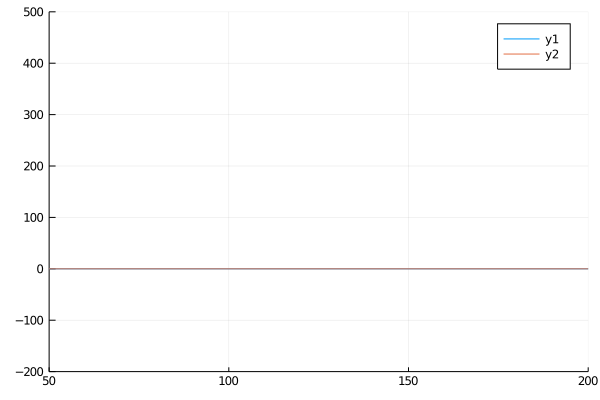

In [14]:
plot(x/1e3,terrace_z[:,20])
plot!(x/1e3,river_z[:,20])
xlims!(50,200)
ylims!(-200,500)